In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
import pandas as pd
import seaborn as sns

In [3]:
test_result = pd.read_csv("./q2_test_results.csv")
users = pd.read_csv("./q2_user_table.csv")

In [4]:
test_result.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [5]:
users.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [6]:
test_result.isna().sum()

user_id             0
timestamp           0
source              0
device              0
operative_system    0
test                0
price               0
converted           0
dtype: int64

In [7]:
users.isna().sum()

user_id    0
city       0
country    0
lat        0
long       0
dtype: int64

There are no nulls

In [8]:
test_result.dtypes

user_id              int64
timestamp           object
source              object
device              object
operative_system    object
test                 int64
price                int64
converted            int64
dtype: object

In [9]:
users.dtypes

user_id      int64
city        object
country     object
lat        float64
long       float64
dtype: object

In [10]:
test_result['test'].value_counts(normalize=True)

0    0.639921
1    0.360079
Name: test, dtype: float64

Seems as quoted 66% Group A & 33% Group B is incorrect, let inspect that again

In [11]:
test_result.groupby(['test', 'price'], as_index=False).size()

,test,price,size
0,0,39,202517
1,0,59,210
2,1,39,155
3,1,59,113918


Some group A users are seeing $\$59$

Some group B users are seeing $\$39$

since the proportion is small lets remove them

In [12]:
test_result = test_result[((test_result.test == 0) & (test_result.price == 39)) | ((test_result.test == 1) & (test_result.price == 59))]


Lets just do the basic EDA, checking all values in each column, any suspicious value

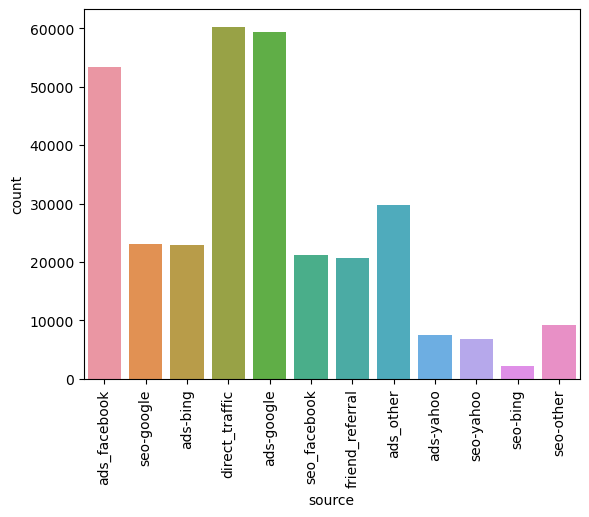

In [13]:
import matplotlib.pyplot as plt

sns.countplot(data=test_result, x='source')
plt.xticks(rotation=90)
plt.show()

Lets split the source into 2 parts, 
1. which can tell us about **`ads, seo, and different website`**
2. which can tell us about the traffic from **`website`**

In [14]:
test_result['source_part1'] = test_result.source.str.split(r'[-,_]', regex=True).str[0]
test_result['source_part2'] = test_result.source.str.split(r'[-,_]', regex=True).str[1]

<AxesSubplot: xlabel='operative_system', ylabel='count'>

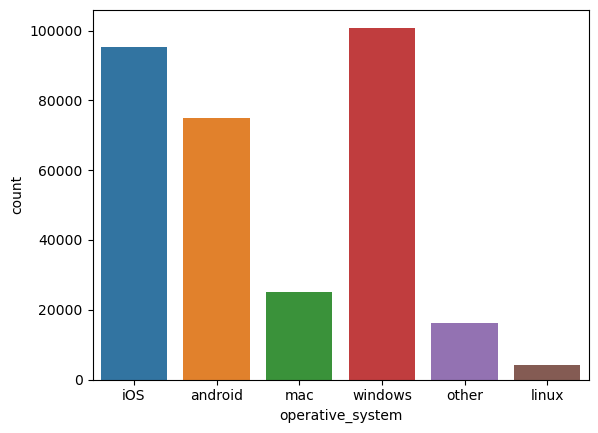

In [15]:
sns.countplot(data=test_result, x='operative_system')

<AxesSubplot: xlabel='device', ylabel='count'>

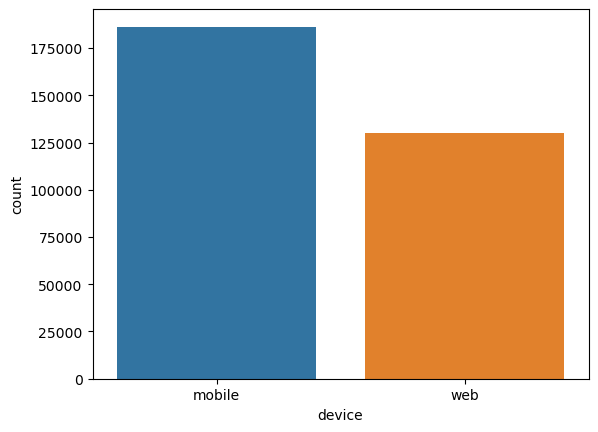

In [16]:
sns.countplot(data=test_result, x='device')

Lets combine two datasets what is there for us

In [17]:
combined_df = pd.merge(test_result, users, on='user_id', how='left')
combined_df.shape

(316435, 14)

Why `left join`?

as we want to keep test_result as it is, our main objective is price optimization and date optimization which is already part of test_result.

In [18]:
test_result.shape

(316435, 10)

In [19]:
users.shape

(275616, 5)

This shows some user in details are missing

In [20]:
combined_df.isna().sum()

user_id                 0
timestamp               0
source                  0
device                  0
operative_system        0
test                    0
price                   0
converted               0
source_part1            0
source_part2            0
city                41141
country             41141
lat                 41141
long                41141
dtype: int64

Some user id's are missing, need to check for them

In [21]:
combined_df[combined_df.city.isna()].groupby(['test', 'converted'], as_index=False).size()

,test,converted,size
0,0,0,25730
1,0,1,546
2,1,0,14623
3,1,1,242


Can't drop the ones which are null as it is significant amount of chunk we are loosing here

In [22]:
group_a_users = set(test_result[test_result['test'] == 0]['user_id'])
group_b_users = set(test_result[test_result['test'] == 1]['user_id'])
users_in_both_groups = list(group_a_users.intersection(group_b_users))
users_in_both_groups

[]

None of the user is present in both the group

Lets build some features around date

In [23]:
test_result['date_time_extracted'] = pd.to_datetime(test_result.timestamp, format='%Y-%m-%d %H:%M:%S', errors='coerce')
test_result.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,source_part1,source_part2,date_time_extracted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,ads,facebook,2015-05-08 03:38:34
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,seo,google,2015-05-10 21:08:46
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,ads,bing,2015-04-04 15:01:23
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,direct,traffic,2015-05-07 07:26:01
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,ads,facebook,2015-05-24 11:04:40


Experienced some date time format are not valid, we have to fix that.

In [24]:
test_result[test_result.date_time_extracted.isna()]

,user_id,timestamp,source,device,operative_system,test,price,converted,source_part1,source_part2,date_time_extracted
54,370914,2015-04-24 12:60:46,direct_traffic,mobile,android,0,39,0,direct,traffic,NaT
104,549807,2015-04-24 11:60:20,friend_referral,mobile,iOS,0,39,0,friend,referral,NaT
121,107010,2015-03-14 12:60:02,direct_traffic,web,windows,0,39,0,direct,traffic,NaT
278,287830,2015-04-04 02:23:60,direct_traffic,web,windows,1,59,0,direct,traffic,NaT
282,676183,2015-05-11 12:60:53,ads-google,web,windows,1,59,0,ads,google,NaT
...,...,...,...,...,...,...,...,...,...,...,...
316566,999430,2015-03-21 16:27:60,friend_referral,web,windows,0,39,0,friend,referral,NaT
316606,256920,2015-05-29 14:34:60,ads_other,mobile,iOS,1,59,0,ads,other,NaT
316709,177121,2015-03-20 18:33:60,ads_facebook,mobile,iOS,0,39,0,ads,facebook,NaT
316756,546292,2015-03-06 22:33:60,seo-yahoo,mobile,iOS,1,59,0,seo,yahoo,NaT


We can see there are some values which are not valid for time. Like the first value has 60 as minute some has 60 as second, where as we know minutes and seconds ranges between 0-59, lets correct it

In [25]:
s = test_result['timestamp'].str.split()
test_result['date_time_extracted'] = pd.to_datetime(s.str[0]) + pd.to_timedelta(s.str[1])

In [26]:
test_result[test_result.date_time_extracted.isna()]

,user_id,timestamp,source,device,operative_system,test,price,converted,source_part1,source_part2,date_time_extracted


As we can nulls are gone

In [27]:
test_result['dt_year'] = test_result['date_time_extracted'].dt.year
test_result['dt_month'] = test_result['date_time_extracted'].dt.month
test_result['dt_day'] = test_result['date_time_extracted'].dt.day
test_result['dt_hour'] = test_result['date_time_extracted'].dt.hour
test_result['dt_day_of_week'] = test_result['date_time_extracted'].dt.day_name()
test_result['dt_week_of_year'] = test_result['date_time_extracted'].dt.weekofyear

/var/folders/6m/c_j082tx0tv_95l5l85yr36r0000gp/T/ipykernel_76385/251826567.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  test_result['dt_week_of_year'] = test_result['date_time_extracted'].dt.weekofyear


In [28]:
test_result.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,source_part1,source_part2,date_time_extracted,dt_year,dt_month,dt_day,dt_hour,dt_day_of_week,dt_week_of_year
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,ads,facebook,2015-05-08 03:38:34,2015,5,8,3,Friday,19
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,seo,google,2015-05-10 21:08:46,2015,5,10,21,Sunday,19
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,ads,bing,2015-04-04 15:01:23,2015,4,4,15,Saturday,14
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,direct,traffic,2015-05-07 07:26:01,2015,5,7,7,Thursday,19
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,ads,facebook,2015-05-24 11:04:40,2015,5,24,11,Sunday,21


<AxesSubplot: xlabel='dt_year', ylabel='count'>

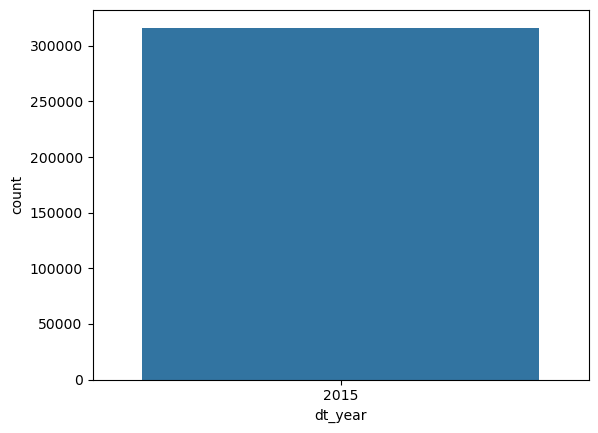

In [29]:
sns.countplot(data=test_result, x='dt_year')

Data is only for 1 year

<AxesSubplot: xlabel='dt_month', ylabel='count'>

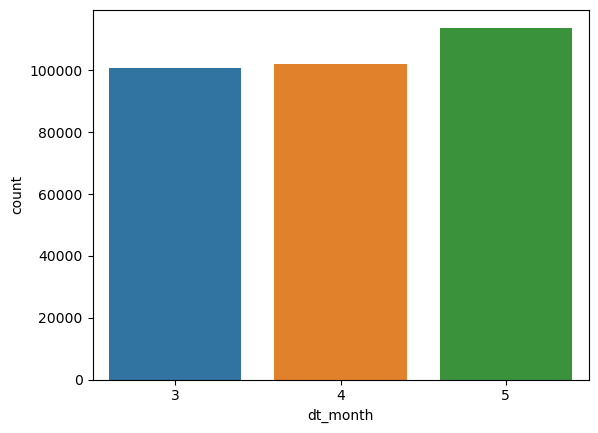

In [30]:
sns.countplot(data=test_result, x='dt_month')

3 months data we have

<AxesSubplot: xlabel='dt_hour', ylabel='count'>

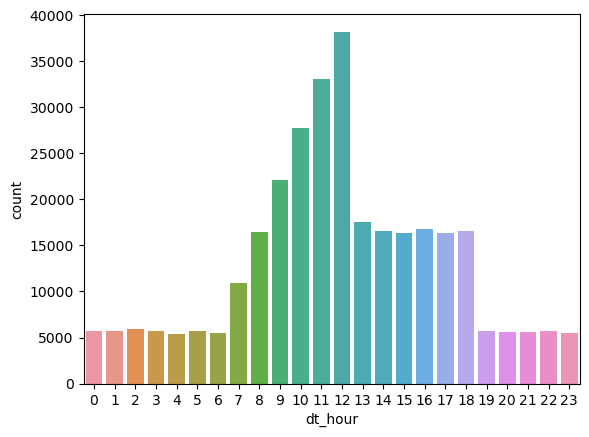

In [31]:
sns.countplot(data=test_result, x='dt_hour')

All the hours data we have, something fishy after 12 all of sudden count drops, lets analyze it later

<AxesSubplot: xlabel='dt_week_of_year', ylabel='count'>

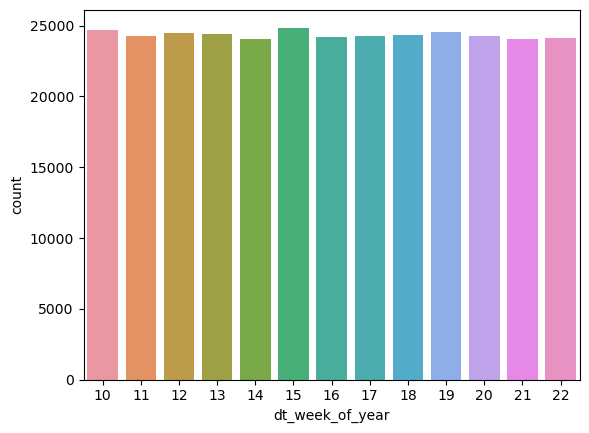

In [32]:
sns.countplot(data=test_result, x='dt_week_of_year')

Every week roughly seeing same number of sessions

<AxesSubplot: xlabel='dt_day_of_week', ylabel='count'>

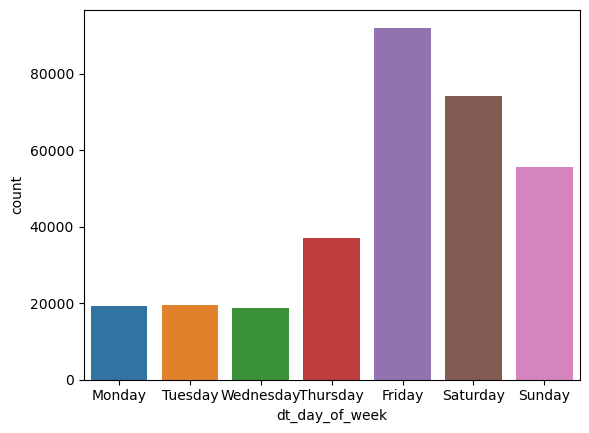

In [33]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

sns.countplot(data=test_result, x='dt_day_of_week', order=days)

Generally traffic builds up near weekend

Data is good for now all the columns consists only logical values now.

Lets now understand the relation of **`conversion rate`** with other variable

<AxesSubplot: xlabel='test', ylabel='converted'>

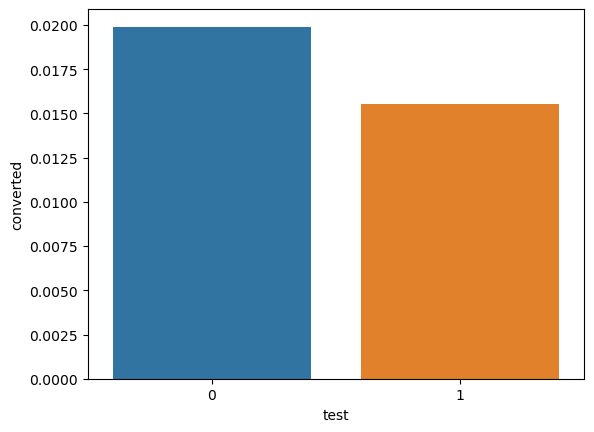

In [34]:
temp_agg = test_result.groupby('test', as_index=False)['converted'].mean()

sns.barplot(data=temp_agg, x='test', y='converted')


Group A is which is test case 0, have higher conversion rate

Group B is which is test case 1, have lower conversion rate

Lets analyse **`sources`**

In [35]:
test_result.groupby(['source'], as_index=False).size()

,source,size
0,ads-bing,22831
1,ads-google,59342
2,ads-yahoo,7571
3,ads_facebook,53355
4,ads_other,29826
5,direct_traffic,60272
6,friend_referral,20678
7,seo-bing,2144
8,seo-google,23148
9,seo-other,9244


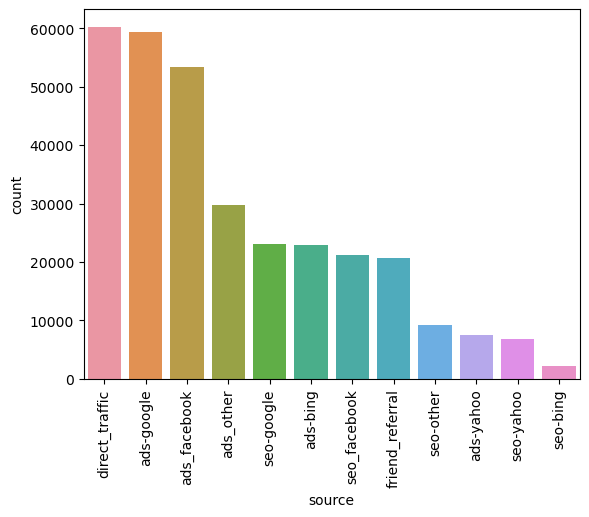

In [36]:
sorted_sources = test_result.groupby('source')['user_id'].count().sort_values(ascending=False).index

sns.countplot(x='source', data=test_result, order=sorted_sources)
plt.xticks(rotation=90)
plt.show()

We can see majority of the traffic is coming from 
1. Direct Traffic
2. Ads Google
3. Ads Facebook

Lets understand the **`source1`**

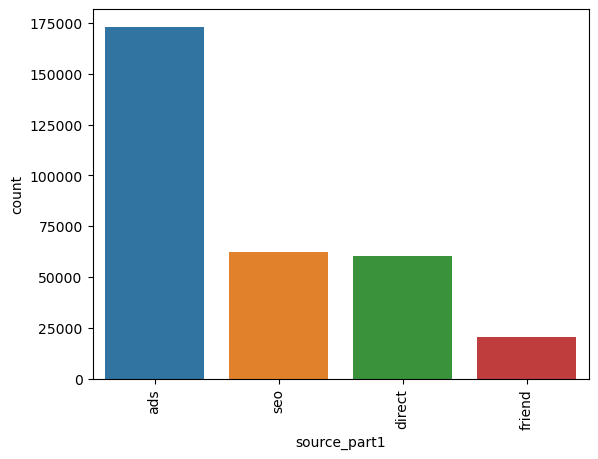

In [37]:
sorted_sources = test_result.groupby('source_part1')['user_id'].count().sort_values(ascending=False).index

sns.countplot(x='source_part1', data=test_result, order=sorted_sources)
plt.xticks(rotation=90)
plt.show()

We can see majority of the traffic is coming from

1. Ads
2. Seo
3. Direct Traffic
4. Friend referral has very less share as compared to other

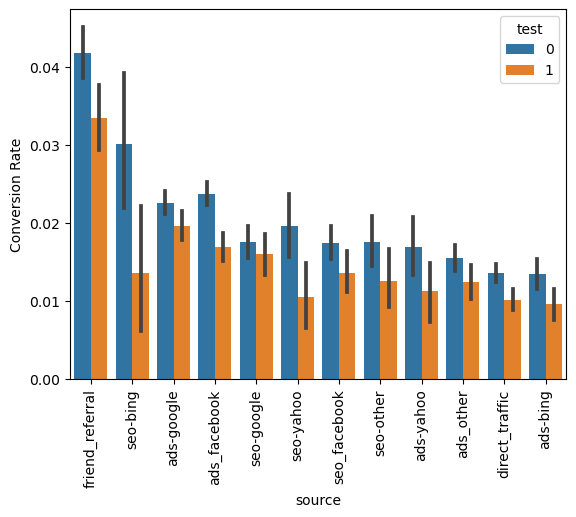

In [38]:
sorted_sources = test_result.groupby('source')['converted'].mean().sort_values(ascending=False).index

sns.barplot(x='source', y='converted', data=test_result, hue='test', order=sorted_sources)
plt.ylabel('Conversion Rate')
plt.xticks(rotation=90)
plt.show()

##### Findings:
**Friend Referrals** - Generate highest conversion rate, hence we should promote it by running some campaign for it

**Seo-bing** has unsual CR for group A

**Group A** has higher conversion rate in general

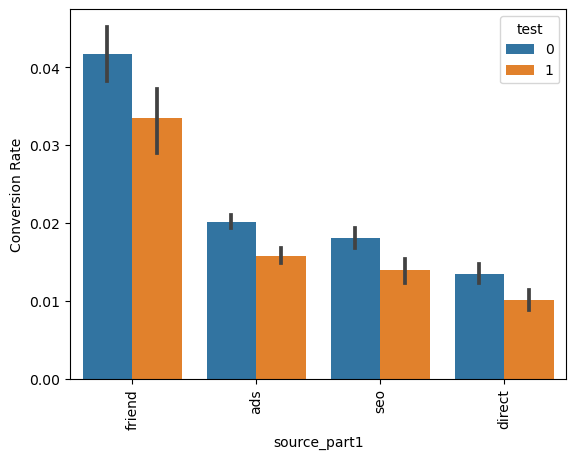

In [39]:
sorted_sources = test_result.groupby('source_part1')['converted'].mean().sort_values(ascending=False).index

sns.barplot(x='source_part1', y='converted', hue='test', data=test_result, order=sorted_sources)
plt.ylabel('Conversion Rate')
plt.xticks(rotation=90)
plt.show()

##### Findings:
Other than friend referrals, ads and seo have same conversion rate, direct has the lowest conversion rate

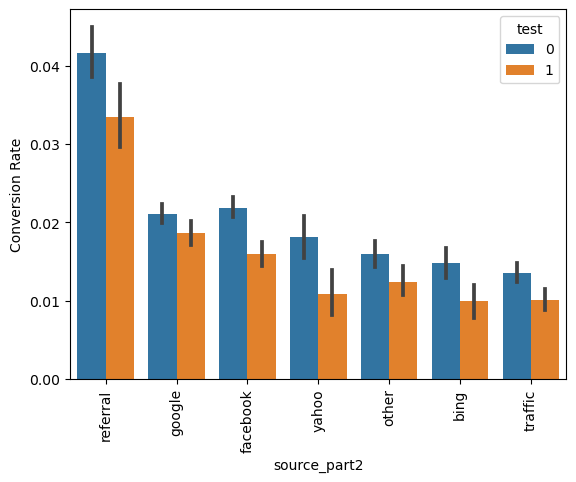

In [40]:
sorted_sources = test_result.groupby('source_part2')['converted'].mean().sort_values(ascending=False).index

sns.barplot(x='source_part2', y='converted', hue='test', data=test_result, order=sorted_sources)
plt.ylabel('Conversion Rate')
plt.xticks(rotation=90)
plt.show()

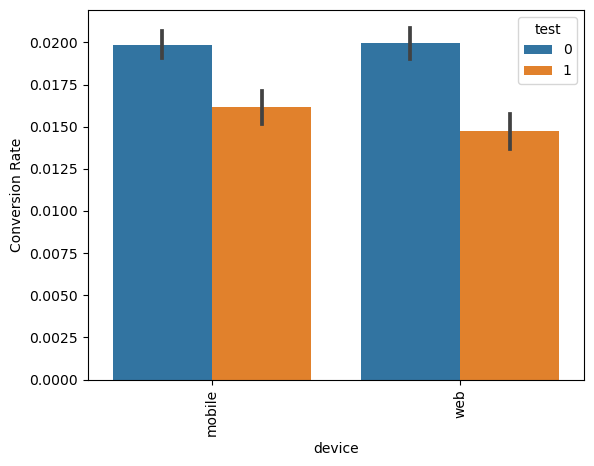

In [41]:
sorted_sources = test_result.groupby('device')['converted'].mean().sort_values(ascending=False).index

sns.barplot(x='device', y='converted', data=test_result, hue='test', order=sorted_sources)
plt.ylabel('Conversion Rate')
plt.xticks(rotation=90)
plt.show()

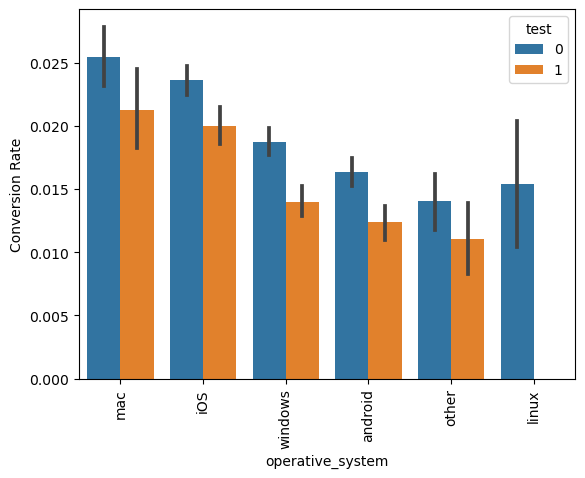

In [42]:
sorted_sources = test_result.groupby('operative_system')['converted'].mean().sort_values(ascending=False).index


sns.barplot(x='operative_system', y='converted', hue='test', data=test_result, order=sorted_sources)
plt.ylabel('Conversion Rate')
plt.xticks(rotation=90)
plt.show()

##### Findings:
Linux has no conversion rate in Group B, how is it possible?
There is some issue with the platform

In [43]:
test_result['weekend'] = test_result['dt_day_of_week'].apply(lambda x: "Weekend" if x in ['Sunday', 'Friday', 'Saturday'] else 'Weekday')

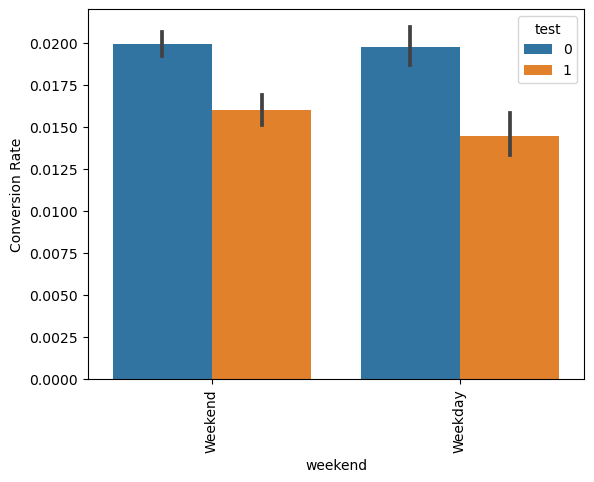

In [44]:
sorted_sources = test_result.groupby('weekend')['converted'].mean().sort_values(ascending=False).index

sns.barplot(x='weekend', y='converted', hue='test', data=test_result, order=sorted_sources)
plt.ylabel('Conversion Rate')
plt.xticks(rotation=90)
plt.show()

<AxesSubplot: xlabel='dt_week_of_year', ylabel='converted'>

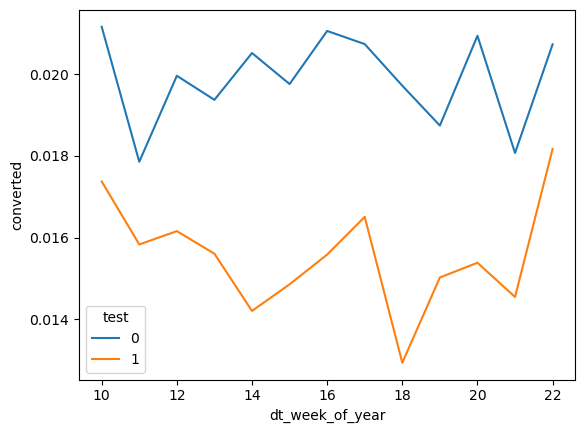

In [45]:
t = test_result.groupby(['dt_week_of_year', 'test'], as_index=False)['converted'].mean()
sns.lineplot(data=t, x='dt_week_of_year', y='converted', hue='test')

##### Findings:
**Weekdays** People surf casualy more
**Weekends** People make more conversions

##### Suggestions:
Run some campaigns on weekdays to convert more.

Lets analyse the **Revenue**

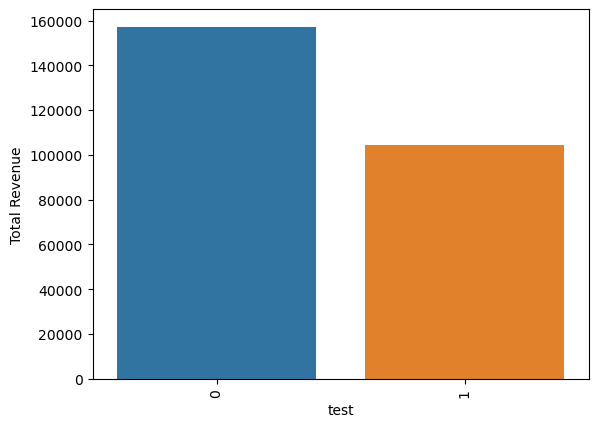

In [46]:
temp = test_result.groupby(['test'], as_index=False).agg({'price':'mean', 'converted':'sum'})
temp['revenue'] = temp['price'] * temp['converted']

sns.barplot(x='test', y='revenue', data=temp)
plt.ylabel('Total Revenue')
plt.xticks(rotation=90)
plt.show()

Majority of our revenue is coming from group A

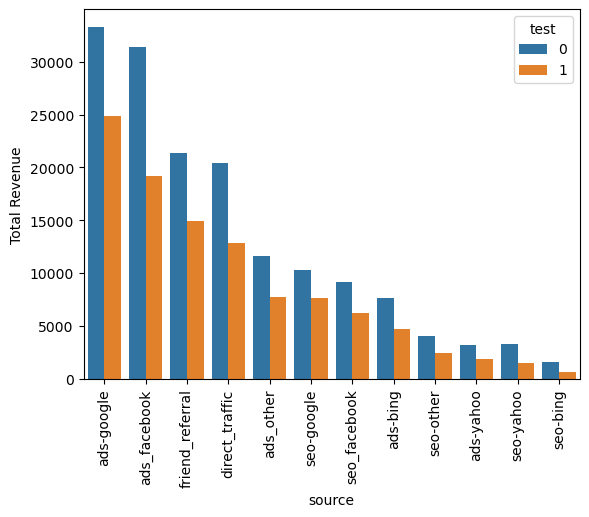

In [47]:
column_of_interest = 'source'

temp = test_result.groupby(['test', column_of_interest], as_index=False).agg({'price':'mean', 'converted':'sum'})
temp['revenue'] = temp['price'] * temp['converted']

sorted_sources = temp.groupby(column_of_interest)['revenue'].mean().sort_values(ascending=False).index

sns.barplot(x=column_of_interest, y='revenue', hue='test', data=temp, order=sorted_sources)
plt.ylabel('Total Revenue')
plt.xticks(rotation=90)
plt.show()

#### Findings:
Majority of the sources are showing group A is making more revenue for us.

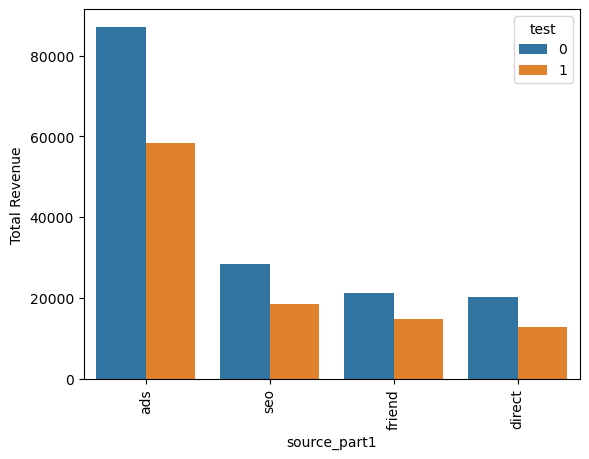

In [49]:
column_of_interest = 'source_part1'

temp = test_result.groupby(['test', column_of_interest], as_index=False).agg({'price':'mean', 'converted':'sum'})
temp['revenue'] = temp['price'] * temp['converted']

sorted_sources = temp.groupby(column_of_interest)['revenue'].sum().sort_values(ascending=False).index

sns.barplot(x=column_of_interest, y='revenue', hue='test', data=temp, order=sorted_sources)
plt.ylabel('Total Revenue')
plt.xticks(rotation=90)
plt.show()

#### Findings:
Majority of the sources are showing group A is making more revenue for us, and majority of it is coming from ads only

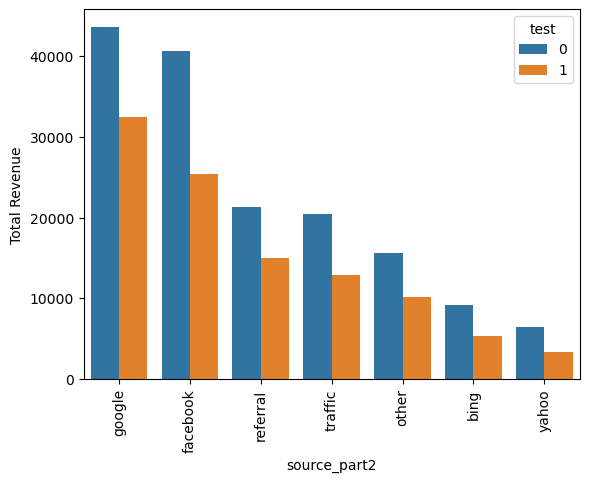

In [51]:
column_of_interest = 'source_part2'

temp = test_result.groupby(['test', column_of_interest], as_index=False).agg({'price':'mean', 'converted':'sum'})
temp['revenue'] = temp['price'] * temp['converted']

sorted_sources = temp.groupby(column_of_interest)['revenue'].sum().sort_values(ascending=False).index

sns.barplot(x=column_of_interest, y='revenue', hue='test', data=temp, order=sorted_sources)
plt.ylabel('Total Revenue')
plt.xticks(rotation=90)
plt.show()

##### Findings:

Google and Facebook fetches us majority of the converted leads revenue

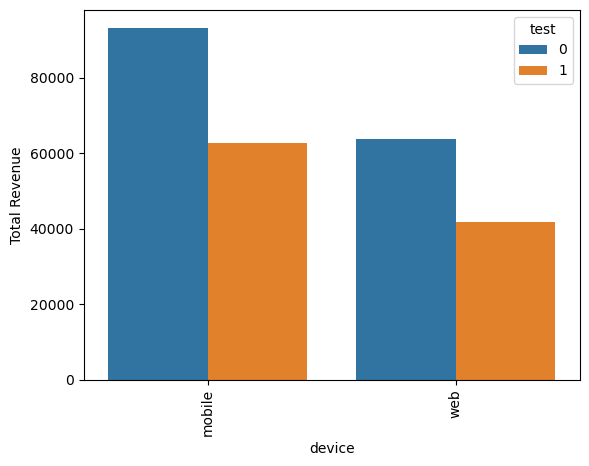

In [53]:
column_of_interest = 'device'

temp = test_result.groupby(['test', column_of_interest], as_index=False).agg({'price':'mean', 'converted':'sum'})
temp['revenue'] = temp['price'] * temp['converted']

sorted_sources = temp.groupby(column_of_interest)['revenue'].sum().sort_values(ascending=False).index

sns.barplot(x=column_of_interest, y='revenue', hue='test', data=temp, order=sorted_sources)
plt.ylabel('Total Revenue')
plt.xticks(rotation=90)
plt.show()

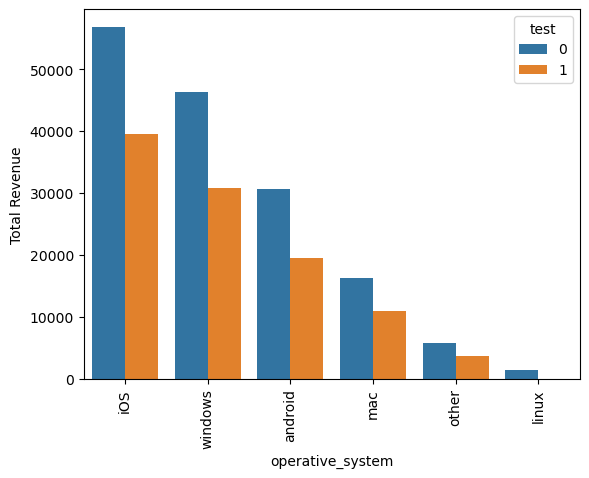

In [54]:
column_of_interest = 'operative_system'
temp = test_result.groupby(['test', column_of_interest], as_index=False).agg({'price':'mean', 'converted':'sum'})
temp['revenue'] = temp['price'] * temp['converted']

sorted_sources = temp.groupby(column_of_interest)['revenue'].sum().sort_values(ascending=False).index

sns.barplot(x=column_of_interest, y='revenue', hue='test', data=temp, order=sorted_sources)
plt.ylabel('Total Revenue')
plt.xticks(rotation=90)
plt.show()

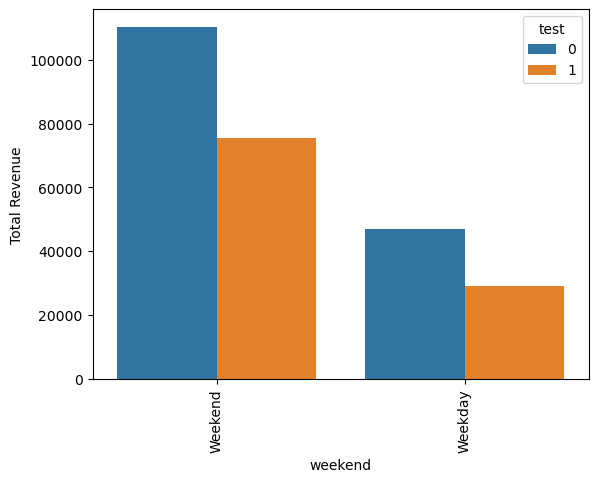

In [55]:
column_of_interest = 'weekend'
temp = test_result.groupby(['test', column_of_interest], as_index=False).agg({'price':'mean', 'converted':'sum'})
temp['revenue'] = temp['price'] * temp['converted']

sorted_sources = temp.groupby(column_of_interest)['revenue'].sum().sort_values(ascending=False).index

sns.barplot(x=column_of_interest, y='revenue', hue='test', data=temp, order=sorted_sources)
plt.ylabel('Total Revenue')
plt.xticks(rotation=90)
plt.show()

Summarising what we saw so far:

1. Price should be kept lower to $39, as we are seeing higher conversion rate for Group A and higher revenue is generated by Group A. Also week on week conversion has dropped for Group B while Group A has consistent conversion rate.
2. Friend Referral and ads have higher conversion rate, hence we should keep our efforts here.
3. Mac and iOS have higher conversion rate hence efforts should be spent there, Windows conversion rate is higher as well as revenue is higher too hence targeted campaign could help to make more out of it.
4. Weekends has higher conversion rate as well as weekend has higher revenue, so discounts or weekend focused efforts can be made.
5. Linux has some issue in Group B, it is not showing any conversion, we need to investigate a cause there.

### Part 3 -> Optimize the number of days that the test

<AxesSubplot: xlabel='dt_week_of_year', ylabel='converted'>

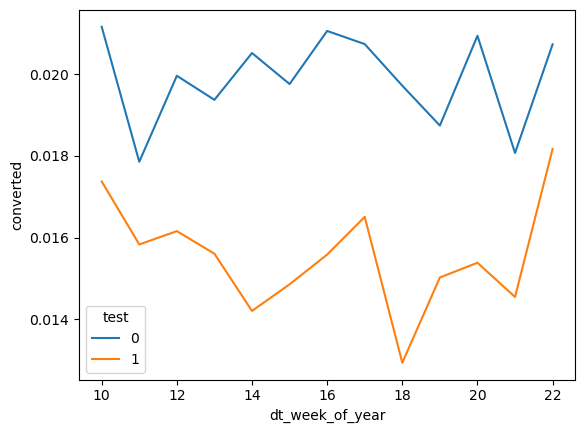

In [56]:
sns.lineplot(data=t, x='dt_week_of_year', y='converted', hue='test')

/var/folders/6m/c_j082tx0tv_95l5l85yr36r0000gp/T/ipykernel_76385/177939146.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_a['date'] = group_a['date_time_extracted'].dt.date
/var/folders/6m/c_j082tx0tv_95l5l85yr36r0000gp/T/ipykernel_76385/177939146.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_b['date'] = group_b['date_time_extracted'].dt.date


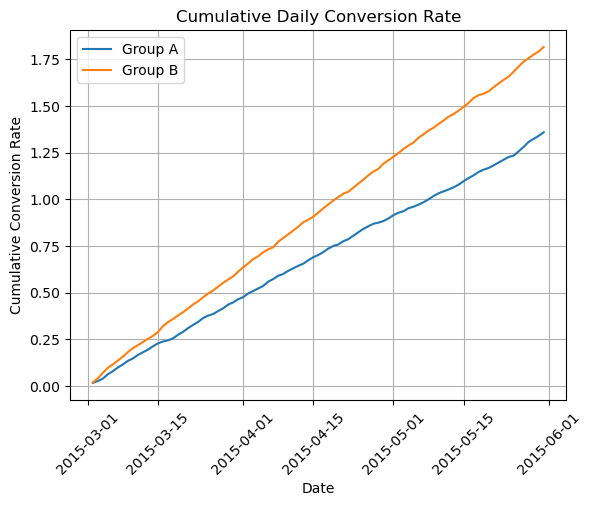

In [57]:
group_a = test_result[test_result['test'] == 1]
group_b = test_result[test_result['test'] == 0]

group_a['date'] = group_a['date_time_extracted'].dt.date
group_b['date'] = group_b['date_time_extracted'].dt.date

group_a_daily_conversion_rate = group_a.groupby('date')['converted'].mean()
group_b_daily_conversion_rate = group_b.groupby('date')['converted'].mean()

group_a_cumulative_conversion_rate = group_a_daily_conversion_rate.cumsum()
group_b_cumulative_conversion_rate = group_b_daily_conversion_rate.cumsum()

plt.plot(group_a_cumulative_conversion_rate.index, group_a_cumulative_conversion_rate, label='Group A')
plt.plot(group_b_cumulative_conversion_rate.index, group_b_cumulative_conversion_rate, label='Group B')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Cumulative Conversion Rate')
plt.title('Cumulative Daily Conversion Rate')
plt.grid()
plt.legend()
plt.show()

Since the above one is kept on increasing and difference between the groups keep getting bigger and bigger. We are unable to see any sign of plateau of the curve hence we should run statistics test to look when the two group become significantly different.

In [58]:
group_a = test_result[test_result['test'] == 1]
group_b = test_result[test_result['test'] == 0]

group_a['date'] = group_a['date_time_extracted'].dt.date
group_b['date'] = group_b['date_time_extracted'].dt.date

group_a_daily_conversion_rate = group_a.groupby('date')['converted'].mean()
group_b_daily_conversion_rate = group_b.groupby('date')['converted'].mean()

/var/folders/6m/c_j082tx0tv_95l5l85yr36r0000gp/T/ipykernel_76385/3826782276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_a['date'] = group_a['date_time_extracted'].dt.date
/var/folders/6m/c_j082tx0tv_95l5l85yr36r0000gp/T/ipykernel_76385/3826782276.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_b['date'] = group_b['date_time_extracted'].dt.date


In [59]:
from scipy.stats import ttest_ind

temp_p_val = []
for day in range(group_a_daily_conversion_rate.shape[0]):
    group_a_till_date_cr = group_a_daily_conversion_rate.iloc[:day].cumsum()
    group_b_till_date_cr = group_b_daily_conversion_rate.iloc[:day].cumsum()
    t, p = ttest_ind(group_a_till_date_cr, group_b_till_date_cr)
    temp_p_val.append(p)

/var/folders/6m/c_j082tx0tv_95l5l85yr36r0000gp/T/ipykernel_76385/486728347.py:7: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t, p = ttest_ind(group_a_till_date_cr, group_b_till_date_cr)
/Users/h/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/Users/h/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


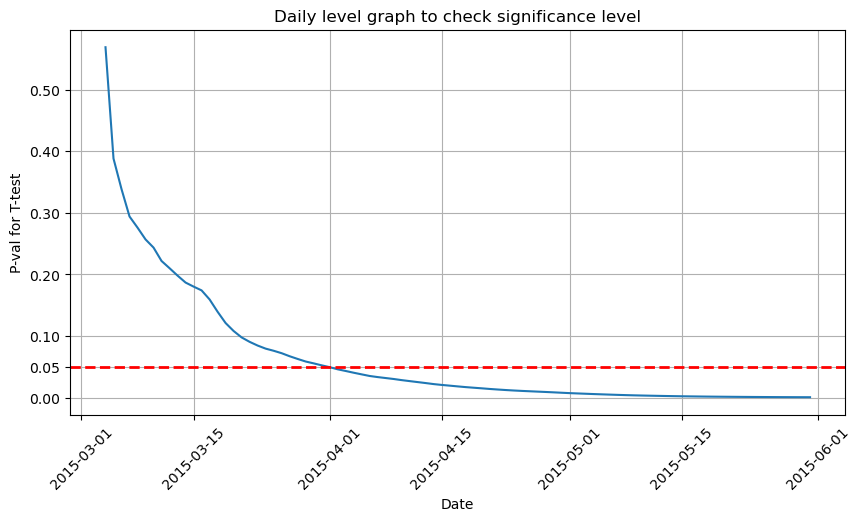

In [60]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(group_a_daily_conversion_rate.index, temp_p_val)
plt.xlabel('Date')
lim = ax.get_ylim()
ax.set_yticks(list(ax.get_yticks()) + [.05])
ax.set_ylim(lim)
plt.xticks(rotation=45)
ax.axhline(y=0.05, color='r', linestyle='--', lw=2)
plt.ylabel('P-val for T-test')
plt.title('Daily level graph to check significance level')
plt.grid()
plt.show()

As we can see from the above graph after 30 days the p-value dropped below 0.05 hence we can say significant difference between the groups. And we can run our further analysis